# 3. Работа с инструментами разметки
Мы видим, что модель некоторые точки неверно детектирует на скачанных нами лицах и
мы хотим отправить эти данные на разметку человеком. Для этого мы хотим в инструмент
для разметки данных загрузить изображения и предсказания модели для последующего
исправления людьми. Соответственно в этом задании нужно:
- завести если нет аккаунт на сервисе [supervisely](https://supervise.ly/)
- почитать документацию и разобраться с [SDK/Python-API для supervisely](https://sdk.docs.supervise.ly/)
- написать код для загрузки данных в supervisely (в этом же jupyter-notebook)
- загрузить 5-10 изображений и предсказаний модели в supervisely и вставить
скриншот с работающего сервиса
- замерьте скорость разметки и оцените время разметки с нуля и время доразметки
результатов работы модели

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#загрузим изображения и координаты точек
data_points = pd.read_pickle('data_points.pickle')

In [3]:
data_points.head()

,Image,GT,Detected
0,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,...","[[66.0335639098, 39.0022736842], [30.227007518...","[[66.0, 39.0], [29.25, 36.75], [58.0, 40.0], [..."
1,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,...","[[64.3329361702, 34.9700765957], [29.949276595...","[[63.75, 34.5], [30.0, 32.5], [56.0, 36.0], [7..."
2,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,...","[[65.0570526316, 34.9096421053], [30.903789473...","[[64.5, 35.5], [30.5, 35.5], [58.0, 36.0], [70..."
3,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,...","[[65.2257391304, 37.261773913], [32.0230956522...","[[65.75, 37.5], [31.25, 37.5], [59.0, 39.0], [..."
4,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,...","[[66.7253006135, 39.6212613497], [32.244809816...","[[65.25, 38.5], [28.5, 37.5], [57.0, 39.0], [7..."


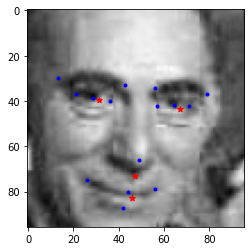

In [4]:
#проверим, что все отрисовывается
plt.imshow(data_points['Image'][7048], cmap='gray')
for l in data_points['GT'][7048]:
    plt.scatter(x=l[0], y=l[1], color='red', marker='*')
for l in data_points['Detected'][7048]:
    plt.scatter(x=l[0], y=l[1], color='blue', marker='.')
plt.show()

In [5]:
import supervisely as sly

In [6]:
api = sly.Api(server_address="https://app.supervise.ly", token="i8FcErMdAHSIX06eWPlYqEF9p8j0SKoTnbJZiw35etqcV6EloZZVboBOJ2EP8nWGgsa90X6Yby4n9PiRhL6T3W3AhGesgEJ7g2pk3e9dsawcLeubbPUYS9iWXJv2Bi19")

In [7]:
# create project and dataset
project = api.project.create(workspace_id=85296, name="onecell_test")
dataset = api.dataset.create(project.id, "test_dataset_pre_markup")
dataset_empty = api.dataset.create(project.id, "test_dataset_empty")

Попробуем загрузить пять случайных документов с точностью детектирования, равной 0.
- 7048   
- 5618 
- 5619 
- 5620 
- 4466

In [8]:
img_indices = [7048, 5618, 5619, 5620, 4466]

In [9]:
class_lec = sly.ObjClass('left_eye_center', sly.Point)
class_rec = sly.ObjClass('right_eye_center', sly.Point)
class_leic = sly.ObjClass('left_eye_inner_corner', sly.Point)
class_leoc = sly.ObjClass('left_eye_outer_corner', sly.Point)
class_reic = sly.ObjClass('right_eye_inner_corner', sly.Point)
class_reoc = sly.ObjClass('right_eye_outer_corner', sly.Point)
class_leie = sly.ObjClass('left_eyebrow_inner_end', sly.Point)
class_leoe = sly.ObjClass('left_eyebrow_outer_end', sly.Point)
class_reie = sly.ObjClass('right_eyebrow_inner_end', sly.Point)
class_reoe = sly.ObjClass('right_eyebrow_outer_end', sly.Point)
class_nt = sly.ObjClass('nose_tip', sly.Point)
class_mlc = sly.ObjClass('mouth_left_corner', sly.Point)
class_mrc = sly.ObjClass('mouth_right_corner', sly.Point)
class_mctl = sly.ObjClass('mouth_center_top_lip', sly.Point)
class_mcbl = sly.ObjClass('mouth_center_bottom_lip', sly.Point)
classes = sly.ObjClassCollection([class_lec, class_rec, class_leic, class_leoc, class_reic, class_reoc, class_leie, class_leoe,
                                 class_reie, class_reoe, class_nt, class_mlc, class_mrc, class_mctl, class_mcbl])

meta = sly.ProjectMeta(obj_classes=classes)
api.project.update_meta(project.id, meta)

In [10]:
# загружаем изображения без аннотаций в датасет "test_dataset_empty"
img_names = ['7048.jpg', '5618.jpg', '5619.jpg', '5620.jpg', '4466.jpg']
img_nps = list(data_points.loc[img_indices, 'Image'])

img_infos = api.image.upload_nps(dataset_empty.id, names=img_names, imgs=img_nps)

In [11]:
# загрузка данных с аннотациями в датасет "test_dataset_pre_markup"
for i in img_indices:
    img_np = data_points.loc[i, 'Image']
    img_name = str(i) + '.jpg'
    img_info = api.image.upload_np(dataset.id, name=img_name, img=img_np)
    
    ann = sly.Annotation((96, 96))

    label_lec = sly.Label(sly.Point(data_points.loc[i, 'Detected'][0][1], data_points.loc[i, 'Detected'][0][0]), class_lec)
    ann = ann.add_label(label_lec)
    
    label_rec = sly.Label(sly.Point(data_points.loc[i, 'Detected'][1][1], data_points.loc[i, 'Detected'][1][0]), class_rec)
    ann = ann.add_label(label_rec)
    
    label_leic = sly.Label(sly.Point(data_points.loc[i, 'Detected'][2][1], data_points.loc[i, 'Detected'][2][0]), class_leic)
    ann = ann.add_label(label_leic)
    
    label_leoc = sly.Label(sly.Point(data_points.loc[i, 'Detected'][3][1], data_points.loc[i, 'Detected'][3][0]), class_leoc)
    ann = ann.add_label(label_leoc)
    
    label_reic = sly.Label(sly.Point(data_points.loc[i, 'Detected'][4][1], data_points.loc[i, 'Detected'][4][0]), class_reic)
    ann = ann.add_label(label_reic)
    
    label_reoc = sly.Label(sly.Point(data_points.loc[i, 'Detected'][5][1], data_points.loc[i, 'Detected'][5][0]), class_reoc)
    ann = ann.add_label(label_reoc)
    
    label_leie = sly.Label(sly.Point(data_points.loc[i, 'Detected'][6][1], data_points.loc[i, 'Detected'][6][0]), class_leie)
    ann = ann.add_label(label_leie)
    
    label_leoe = sly.Label(sly.Point(data_points.loc[i, 'Detected'][7][1], data_points.loc[i, 'Detected'][7][0]), class_leoe)
    ann = ann.add_label(label_leoe)
    
    label_reie = sly.Label(sly.Point(data_points.loc[i, 'Detected'][8][1], data_points.loc[i, 'Detected'][8][0]), class_reie)
    ann = ann.add_label(label_reie)
    
    label_reoe = sly.Label(sly.Point(data_points.loc[i, 'Detected'][9][1], data_points.loc[i, 'Detected'][9][0]), class_reoe)
    ann = ann.add_label(label_reoe)
    
    label_nt = sly.Label(sly.Point(data_points.loc[i, 'Detected'][10][1], data_points.loc[i, 'Detected'][10][0]), class_nt)
    ann = ann.add_label(label_nt)
    
    label_mlc = sly.Label(sly.Point(data_points.loc[i, 'Detected'][11][1], data_points.loc[i, 'Detected'][11][0]), class_mlc)
    ann = ann.add_label(label_mlc)
    
    label_mrc = sly.Label(sly.Point(data_points.loc[i, 'Detected'][12][1], data_points.loc[i, 'Detected'][12][0]), class_mrc)
    ann = ann.add_label(label_mrc)
    
    label_mctl = sly.Label(sly.Point(data_points.loc[i, 'Detected'][13][1], data_points.loc[i, 'Detected'][13][0]), class_mctl)
    ann = ann.add_label(label_mctl)
    
    label_mcbl = sly.Label(sly.Point(data_points.loc[i, 'Detected'][14][1], data_points.loc[i, 'Detected'][14][0]), class_mcbl)
    ann = ann.add_label(label_mcbl)
    
    upl_ann = api.annotation.upload_ann(img_info.id, ann)

Скриншоты работающегго сервиса:
1. Workplace
![workplace](supervisely_1.png)

2. Проект
![project](supervisely_2.png)

3. Датасеты 
![datasets](supervisely_3.png)

4. Изображение с предразметкой
![image_with_premarkup](supervisely_4.png)

Разметка пяти предразмеченных изображений заняла 4 минуты.<br>
Разметка тех же пяти изображений с нуля заняла 7 минут.